In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
customers_df = pd.read_csv("./Customers.csv")
products_df = pd.read_csv("./Products.csv")
transactions_df = pd.read_csv("./Transactions.csv")

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [4]:
# Merge customers with transactions
customer_transactions = pd.merge(transactions_df, customers_df, on="CustomerID", how="inner")

# Merge the result with products
full_data = pd.merge(customer_transactions, products_df, on="ProductID", how="inner")

# Aggregate data to create customer profiles
customer_profiles = full_data.groupby("CustomerID").agg(
    TotalSpend=("TotalValue", "sum"),
    PurchaseFrequency=("TransactionID", "count"),
    AverageTransactionValue=("TotalValue", "mean"),
    Region=("Region", "first"),
).reset_index()

customer_profiles.sample(10)

,CustomerID,TotalSpend,PurchaseFrequency,AverageTransactionValue,Region
63,C0064,4039.77,5,807.954000,Europe
156,C0157,1876.10,5,375.220000,North America
140,C0141,10673.87,10,1067.387000,Europe
50,C0051,5699.57,7,814.224286,Europe
97,C0098,3158.02,8,394.752500,North America
175,C0176,2331.32,3,777.106667,North America
136,C0137,3332.55,5,666.510000,South America
13,C0014,318.66,1,318.660000,Europe
66,C0067,4090.84,6,681.806667,North America
120,C0121,974.52,4,243.630000,Europe


In [5]:
print(customer_profiles.columns)

Index(['CustomerID', 'TotalSpend', 'PurchaseFrequency',
       'AverageTransactionValue', 'Region'],
      dtype='object')


In [6]:
# Using the correct column name
customer_profiles['TotalSpend'] = customer_profiles['TotalSpend']
customer_profiles['PurchaseFrequency'] = customer_profiles['PurchaseFrequency']
customer_profiles['AverageTransactionValue'] = customer_profiles['TotalSpend'] / customer_profiles['PurchaseFrequency']

customer_profiles['AverageTransactionValue'] = customer_profiles['AverageTransactionValue'].replace([np.inf, -np.inf], 0)
customer_profiles.loc[customer_profiles['AverageTransactionValue'] > 1000, 'AverageTransactionValue'] = 1000  

In [7]:
numerical_features = ["TotalSpend", "PurchaseFrequency", "AverageTransactionValue"]
categorical_features = ["Region"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
    ]
)

prepared_data = preprocessor.fit_transform(customer_profiles)

processed_columns = (
    numerical_features + preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features).tolist()
)
prepared_df = pd.DataFrame(prepared_data, columns=processed_columns)

prepared_df.head()

,TotalSpend,PurchaseFrequency,AverageTransactionValue,Region_Asia,Region_Europe,Region_North America,Region_South America
0,-0.061701,-0.011458,-0.017320,0.0,0.0,0.0,1.0
1,-0.877744,-0.467494,-0.980339,1.0,0.0,0.0,0.0
2,-0.405857,-0.467494,0.031676,0.0,0.0,0.0,1.0
3,1.032547,1.356650,-0.024566,0.0,0.0,0.0,1.0
4,-0.783929,-0.923530,0.016354,1.0,0.0,0.0,0.0


In [8]:
prepared_df.columns

Index(['TotalSpend', 'PurchaseFrequency', 'AverageTransactionValue',
       'Region_Asia', 'Region_Europe', 'Region_North America',
       'Region_South America'],
      dtype='object')

In [9]:
features = [
    'TotalSpend', 
    'PurchaseFrequency', 
    'AverageTransactionValue',
    'Region_Asia', 
    'Region_Europe', 
    'Region_North America',
    'Region_South America'
]
X = prepared_df[features].dropna()

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

In [11]:
wcss = []
db_scores = []
silhouette_scores = []
cluster_counts = range(2, 11)

# Perform K-Means clustering for cluster counts between 2 and 10
for k in cluster_counts:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)

    wcss.append(kmeans.inertia_)
    db_index = davies_bouldin_score(X, labels)
    db_scores.append((k, db_index))

    score = silhouette_score(X, labels)
    silhouette_scores.append((k, score))

# Identify the optimal number of clusters based on the lowest DB Index
optimal_clusters = sorted(db_scores, key=lambda x: x[1])[0][0]
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42)
prepared_df['Cluster'] = kmeans_optimal.fit_predict(X)

In [12]:
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42)
prepared_df['Cluster'] = kmeans_optimal.fit_predict(X)

In [13]:
wcss, optimal_clusters

([488.00510462936654,
  405.14844022114954,
  336.6144404910352,
  288.76435304079655,
  272.74094863154477,
  249.67220649274077,
  236.77423686486677,
  221.30499251672524,
  202.63325829748834],
 10)

In [14]:
db_scores, optimal_clusters

([(2, 1.2740720851562748),
  (3, 1.4040411511635629),
  (4, 1.3368289911774993),
  (5, 1.2897566596189824),
  (6, 1.4173731227107285),
  (7, 1.3354570311039062),
  (8, 1.3990862034059435),
  (9, 1.423935522238978),
  (10, 1.2689528506913055)],
 10)

In [15]:
silhouette_scores, optimal_clusters

([(2, 0.2916580864361092),
  (3, 0.22193511311889455),
  (4, 0.2295717912491519),
  (5, 0.2291313633067483),
  (6, 0.19896011443631378),
  (7, 0.212762391764563),
  (8, 0.21832630331267613),
  (9, 0.2209562024661767),
  (10, 0.262783392714867)],
 10)

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X[features])
X['PCA1'] = X_pca[:, 0]
X['PCA2'] = X_pca[:, 1]

Text(0, 0.5, 'WCSS')

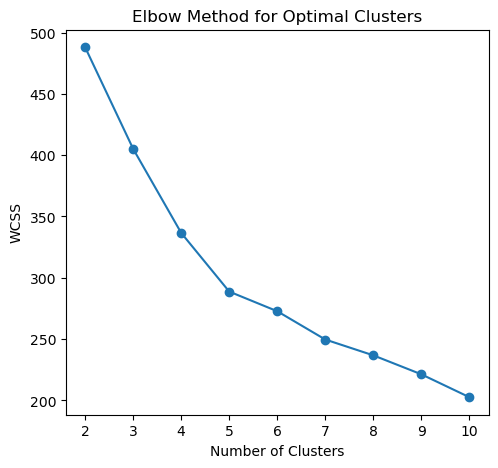

In [17]:
plt.figure(figsize=(12, 5))

# Plot WCSS
plt.subplot(1, 2, 1)
plt.plot(cluster_counts, wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

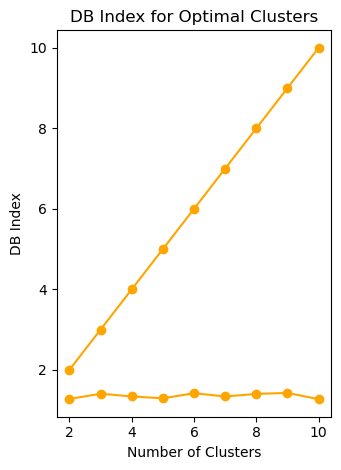

In [18]:
plt.subplot(1, 2, 2)
plt.plot(cluster_counts, db_scores, marker='o', color='orange')
plt.title('DB Index for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')

plt.tight_layout()
plt.show()

In [19]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

prepared_df["PCA1"] = pca_result[:, 0]
prepared_df["PCA2"] = pca_result[:, 1]


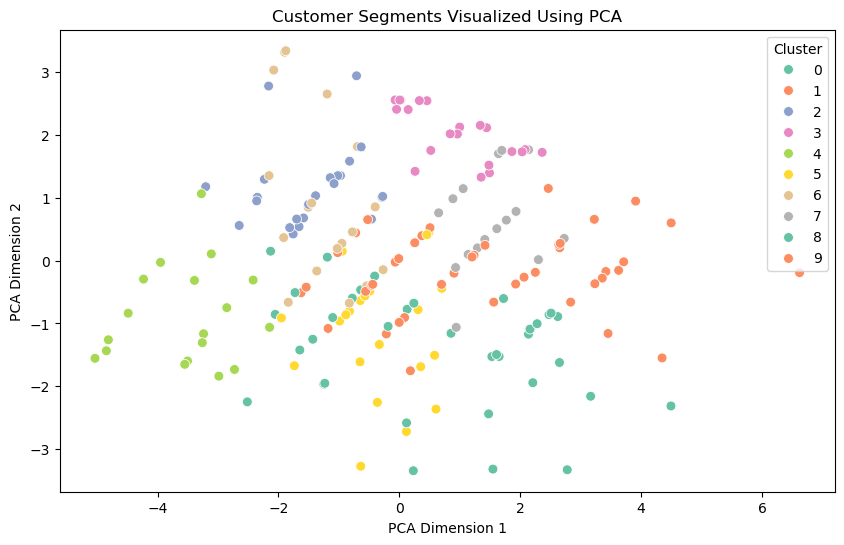

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=prepared_df, palette="Set2", s=50)
plt.title("Customer Segments Visualized Using PCA")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

In [21]:
optimal_db_index = min(db_scores, key=lambda x: x[1])[1]
silhouette_optimal = silhouette_scores[optimal_clusters - 2]


print("Clustering Metrics Summary:")
print(f"Optimal Clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {optimal_db_index:.2f}")
print(f"Silhouette Score: {silhouette_optimal}")

Clustering Metrics Summary:
Optimal Clusters: 10
Davies-Bouldin Index: 1.27
Silhouette Score: (10, 0.262783392714867)
